# `DSML Workshop 09` - Advanced Non-Linear Regression

In this workshop we continue with hands-on supervised learning (regression). We continue 

We will cover the following: 
1. Regularization: L1 (LASSO) and L2 (ridge) regression
1. General non-linear features: Radial Basis Functions
1. Other regression algorithms: Overview of some selected algorithms  


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

## Example: predicting peak electrical power

We continue with our electric power example from last week which we retieved from PJM from the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [2]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)
df.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1
2,2013-01-03,1.832822,2.049550,0.001833,43.991607,0.6,-6.12,1
3,2013-01-04,1.812699,2.008168,0.001813,43.508609,0.0,-1.95,1
4,2013-01-05,1.662036,1.838251,0.001662,39.892360,1.7,-1.47,1


## `Recap`

**Recall from previous workshop**: We fitted a polynomial model to the full range of electricity data. To do so we used `scikit learn` and obtained the following result:

In [3]:
xp = df["High_temp"].values
yp = df["MAX"].values

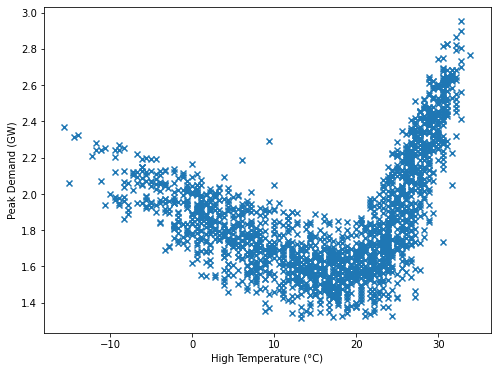

In [4]:
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [5]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # rescale to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using analytical least squares solution
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])

[ 423047.66234686 -322876.57104631  156677.85212464  258215.23193553]


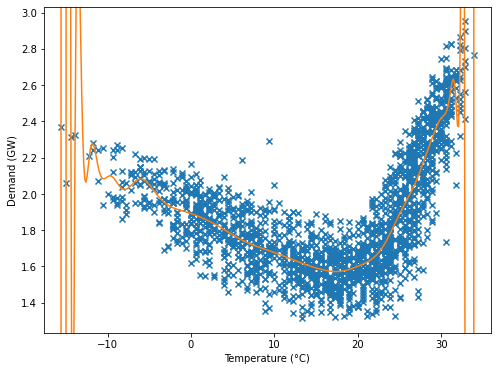

In [7]:
plot_regression_poly(xp, yp, d=100)

## `Regularization` (by hand)

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data.

Let's also look at the actual weights involved with this fit.

[ 423047.66234686 -322876.57104631  156677.85212464  258215.23193553]


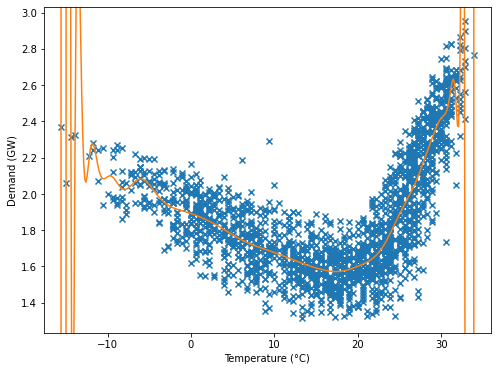

In [8]:
plot_regression_poly(xp, yp, d=100)

The way that we get the polynomial to exactly pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely “cancel” out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: 
restircting the magnitude of the coefficients. This is the basis of the technique known as regularization.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimizaiton problem:
\begin{equation}
\min \theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.

### Visualizing regularization
Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

In [9]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)  # see lecture notes for derivation!, where np.eye() returns the identity matrix
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_Regularised reg_'+str(d)+'.png', dpi = 300)
    
    #return theta

[ 0.01586789 -0.10589883  0.01414963 -0.10185581]


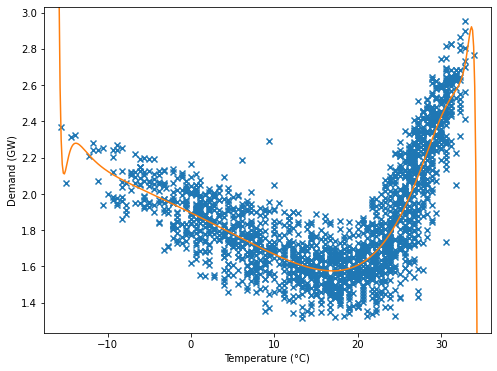

In [15]:
plot_regularized_polyregression (xp, yp, lam=0.1, d=100)

What happens if we regularize further? As we increase labmda, the underlying function looks generally smoother (again, focusing mainly here on the data between the extreme points).

[-0.00128759 -0.00283355 -0.00129545 -0.0028345 ]


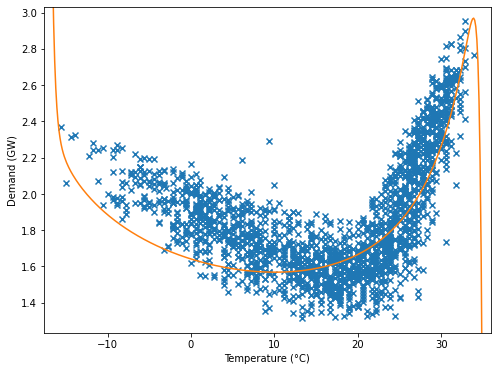

In [16]:
plot_regularized_polyregression (xp, yp, lam=100, d=100)

We can also understand what is happening here by reference to the previous section when we discussed polynomial fittings as a function of the degree of the polynomial.  Remember that after degree 10 or so, there wasn't a huge benefit to including additional polynomial terms in the regression.  Yet, if include these terms within the context of a tradition least squares fit, we have seen that in order to use the polynomial degree to minimize the error (essentially done by "exactly" passing through some of the points), this is accomplished by a very high weight on the high-order coefficients.

So what happens when we apply a regularization penalty?  Because we know that we can achieve low error with a lower-degree polynomial of relatively small weights, if we add sufficient regularization to the optimization objective, this will have the effect of avoiding putting much weight on the high-order terms in the polynomial, and just putting the weight on the lower order terms.  We can view this by looking at the magnitude of the actual coefficients of $\theta$ before and after regularization (remember, $\theta$ is ordered in higher-to-lower degree polynomial terms, so we will flip the order to correspond to increasing degree of the polynomial terms.

In [17]:
def ls_poly_reg(x, y, lam, degree):
    xs = 2*(x - min(x))/(max(x) - min(x)) - 1   # rescale to range [-1,1]
    X = np.array([xs**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

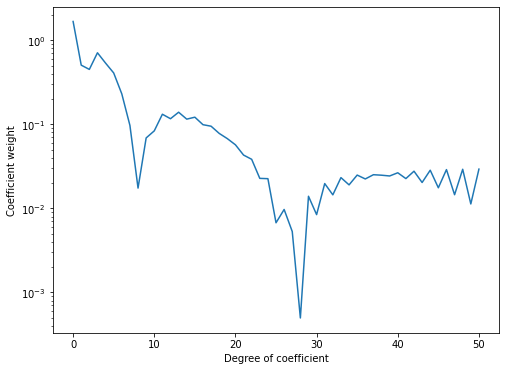

In [27]:
# Define inputs
x=xp
y=yp
lam=1
degree= 50

# Plot function
theta = ls_poly_reg(x, y, lam, degree)

plt.figure(figsize = (8,6))
plt.semilogy(range(degree+1), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")
plt.show()

**What do you observe as you change the degree of polynomial and the regularization parameter?**

## Regularization using `scikit learn`

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This is the process we have implemented manually above. It proceeds by penalizing the sum of squares (L2-norm) of the model coefficients; in this case, the penalty on the model fit would be $P = \alpha\sum_{n=1}^N \theta_n^2$ where $\alpha$ is a free parameter that controls the strength of the penalty (not that this is equivalent to our $\lambda$ from above). This type of penalized model is built into Scikit-Learn with the Ridge estimator:

First we need to create polynomial features using the `PolynomialFeatures` module in `scikit learn`

In [28]:
from sklearn.preprocessing import PolynomialFeatures

# initialize model
Poly = PolynomialFeatures(degree = 50)

# fit and transform xp
X_poly = Poly.fit_transform(xp.reshape(-1,1))

We then import the `Ridge` regression model

In [32]:
from sklearn.linear_model import Ridge

model_L2 = Ridge(alpha = 0.01, normalize = True, solver = 'lsqr') # select least squares regression as solver

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00 -2.32640141e-02  5.84347924e-05  6.13898052e-06
  3.33662650e-07  1.07952528e-08  3.27215854e-10  8.81663013e-12
  2.23665684e-13  5.17885431e-15  1.07560117e-16  1.79689238e-18
  1.39128809e-20 -6.59554607e-22 -4.74124289e-23 -2.09838984e-24
 -7.84618536e-26 -2.67816111e-27 -8.60338073e-29 -2.63977107e-30
 -7.79437033e-32 -2.22231243e-33 -6.12133462e-35 -1.62513656e-36
 -4.13374005e-38 -9.95388249e-40 -2.21399631e-41 -4.29129615e-43
 -5.93554881e-45  2.09363482e-47  6.17553472e-48  3.35292651e-49
  1.39778610e-50  5.17393937e-52  1.78342400e-53  5.84705960e-55
  1.84300545e-56  5.61572341e-58  1.65785897e-59  4.74022713e-61
  1.30860068e-62  3.46361529e-64  8.66817836e-66  1.99233509e-67
  3.90866418e-69  4.88106818e-71 -7.53423952e-73 -9.32437350e-74
 -5.01593599e-75 -2.19332730e-76 -8.69503304e-78] 
Intercept  1.8846505592013083


In [33]:
# function for plotting

def plot_scikit_output (x, y, fitted_model):
    
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)

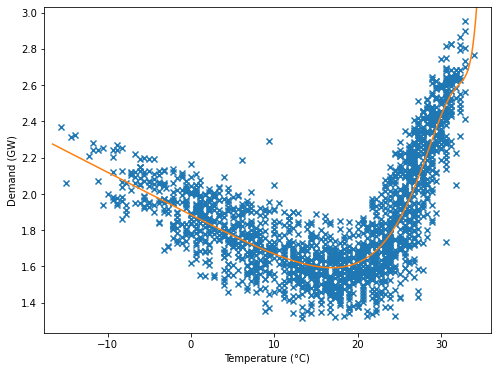

In [34]:
plot_scikit_output (xp, yp, model_L2)

### LASSO regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: $$
P = \alpha\sum_{n=1}^N |\theta_n|
$$ Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.


In [36]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 1)

model_L1.fit(X_poly, yp)
predict = model_L1.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00 -2.32640141e-02  5.84347924e-05  6.13898052e-06
  3.33662650e-07  1.07952528e-08  3.27215854e-10  8.81663013e-12
  2.23665684e-13  5.17885431e-15  1.07560117e-16  1.79689238e-18
  1.39128809e-20 -6.59554607e-22 -4.74124289e-23 -2.09838984e-24
 -7.84618536e-26 -2.67816111e-27 -8.60338073e-29 -2.63977107e-30
 -7.79437033e-32 -2.22231243e-33 -6.12133462e-35 -1.62513656e-36
 -4.13374005e-38 -9.95388249e-40 -2.21399631e-41 -4.29129615e-43
 -5.93554881e-45  2.09363482e-47  6.17553472e-48  3.35292651e-49
  1.39778610e-50  5.17393937e-52  1.78342400e-53  5.84705960e-55
  1.84300545e-56  5.61572341e-58  1.65785897e-59  4.74022713e-61
  1.30860068e-62  3.46361529e-64  8.66817836e-66  1.99233509e-67
  3.90866418e-69  4.88106818e-71 -7.53423952e-73 -9.32437350e-74
 -5.01593599e-75 -2.19332730e-76 -8.69503304e-78] 
Intercept  1.8846505592013083


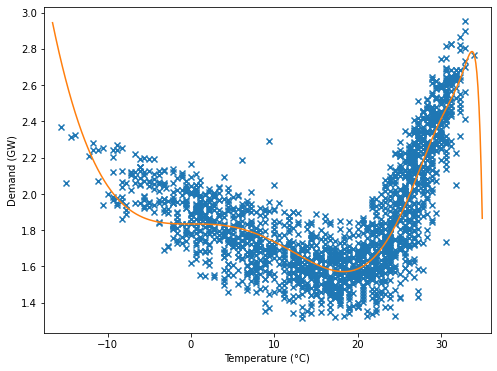

In [37]:
plot_scikit_output (xp, yp, model_L1)

### Regularization and cross-validation performance

We can also illustrate the effects of regularization as they relate to training and validation performance.  Just as we did with the degree of the polynomial, we can consider the training and validation errors for different amounts of regularization.

In [39]:
def plot_L2_regression_performance (x, y, deg):

    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

    for alpha in np.logspace(-15,10,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
        prediction = model_L2.predict(X_test_poly)

        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

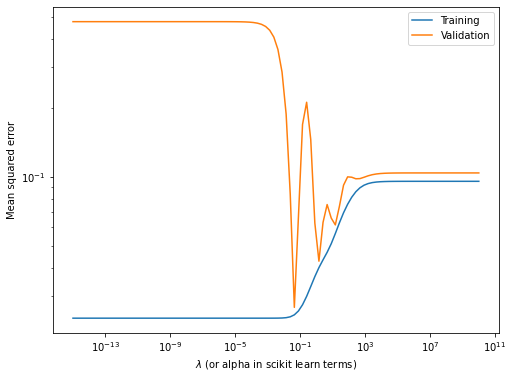

In [42]:
plot_L2_regression_performance(xp,yp,100)

A few points are worth emphasizing here.  First, the nature of the regularization term: lower $\lambda$ means _less_ regularization, whereas large $\lambda$ mean more regularization (eventually just essentially corresponding to all zero weights) results in the above shape.  Thus, larger $\lambda$ means _lower_ model complexity, so the x-axis of the figure works in the opposite direction as in the polynomial degree example.  Second, also note that we are using a _logarithmic_ scale on the x-axis (and the y-axis, as before, but the x-axis is the important part here).  This means that regularization typically works on a scale of _orders of magnitude_.  If you search over possible regularization terms, you'll want to do this search over a logarithmic space, because you need very large changes to the magnitude of $\lambda$ to really illustrate the full differences.  Third and last, just as was the case for the polynomial degree, we emphasize that the cross validation error is not a nice unimodal function of $\lambda$; there are multiple local optima owing to the pecularities of the particular polynomial, and it is not easy to globally optimize $\lambda$ by looking at cross validation error in some local region alone.  For this reason, techniques like grid searches are often more common in practice for finding model hyperparamters (including the $\lambda$ term), instead of techniques like gradient-based optimization.

**Exercise**: Write a small function to visualize how the $MSE$ improves as you increase $\alpha$ for a fixed choice of polynomial degree in LASSO regression.

In [47]:
# YOUR CODE HERE

def plot_L1_regression_performance (x, y, deg):
    
    err_train = []
    err_cv = []
    
    #split data
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)
    
    # loop over alpha
    
    for alpha in np.logspace(-8,3,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L1 = Lasso(alpha = alpha, normalize=True) 
        model_L1.fit(X_train_poly, y_train)
        prediction = model_L1.predict(X_test_poly)

        # compute errors
        err_train.append(mean_squared_error(model_L1.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L1.predict(X_test_poly), y_test))
        
        
    # plot the results
    
    
    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-8,3,100), err_train, np.logspace(-8,3,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

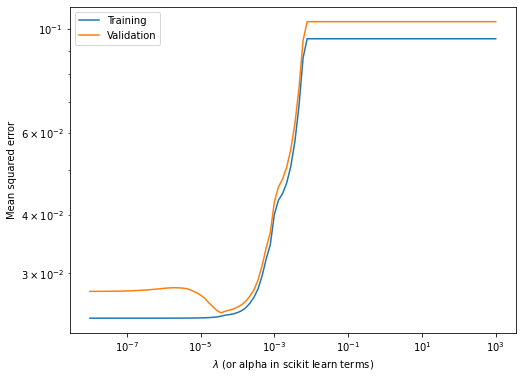

In [48]:
plot_L1_regression_performance (xp, yp, 50)

## General non-linear features

Using polynomials served as as good illustration of the basic principles of nonlinear features, generalization, and regularization, but they are far from the only such type of feature used in practice (and indeed, polynomials are probably a bit less common in most cases than other feature classes.  We also only covered polynomials for one dimensional "raw" inputs, where it was easy to enumerate all possible polynomials.  In this section we'll cover another type of common nonlinear feature, radial basis functions, and illustrate how to create both polynomials and radial basis functions over multi-dimensional raw inputs.

For the purposes of this section, we're going to adopt a slightly more explicit notation, though in general we're going to use it _only_ for this section.  Specifically, whereas before we used $x^{(i)}$ to generally refer to the input features to the algorithm, here we're going to use $x^{(i)} \in \mathbb{R}^n$ (or often just $x \in \mathbb{R}^n$, if we don't need to index over a data set), to refer to just the "raw" input features: i.e., in the case of our peak demand prediction problem $x$ would just refer to the high temperature
\begin{equation}
x^{(i)} \in \mathbb{R}^1 = \left [ \; \mathrm{HighTemperature}^{(i)} \; \right ]
\end{equation}
The raw inputs need not always be one dimensional, of course, for instance we previously used the example of including both the temperature and a day of the week flag as features
\begin{equation}
x^{(i)} \in \mathbb{R}^2 = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)} \\ \mathrm{IsWeekday}^{(i)} \end{array} \right ]
\end{equation}

But note that here we don't include any of the polynomial features directly in $x$; instead, $x$ only captures the tru underlying inputs to the algorithm, the elements that we are providing that are not derived from the other quantities (and note that that it also doesn't include the constant feature, for instance).  Instead, we'll define a _feature mapping_
\begin{equation}
\phi : \mathbb{R}^n \rightarrow \mathbb{R}^k
\end{equation}
to be a function that maps $n$-dimensional inputs to $k$ dimensional _features_.  Everything else remains the same, except that we now consider the hypothesis function that is linear in these feature vectors, i.e.,
\begin{equation}
h_{\theta}(x) = \theta^T \phi(x)
\end{equation}
parameterized by $\theta \in \mathbb{R}^k$.

For example, for a degree-3 polynomial (in one input variable), we can define $\phi : \mathbb{R} \rightarrow \mathbb{R}^4$ as
\begin{equation}
\phi(x) = \left [ \begin{array}{c} x^3 \\ x^2 \\ x \\ 1 \end{array} \right ]
\end{equation}
and similarly for larger degree
polynomials.  Hopefully it is clear that this is just a notational definition, but it is useful for begin a bit more precise about these nonlinear features.

### `Radial basis function (RBF)`

If I were to make a completely anecdotal estimate, I would guess that the most frequently used type of nonlinear feature in not the polynomial, but something called the _radial basis function_ (this is actually the case both for explicit features and for the kernel methods we'll talk about shortly), often abreviated as RBF.  Radial basis functions are similar to polynomials in that they are non-linear functions of the input data, but they are notably different in that they are generally _local_ features: the value of any particular feature is close to zero for most of the input space, but non-zero in a small region around a "center" parameter.  Let's start with the definition, and we can then provide some illustrations that hopefully make this more concrete.  To keep this simple to start, we're only going to consider radial basis functions of one-dimensional raw inputs, though we'll shortly expand this to cover the general $n$-dimensional case.  A radial basis function feature vector is defined as the following:
\begin{equation}
\phi : \mathbb{R} \rightarrow \mathbb{R}^k = \left [ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu_{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right ]
\end{equation}
where $\mu^{(1)},\ldots,\mu^{(k-1)} \in \mathbb{R}$ (called the means) and $\sigma \in \mathbb{R}$ (called the bandwidth) are the hyperparameters of this feature vector.  

Let's look at a single one of these terms $\phi_j(x)$ (this is the $j$th element of the feature vector, because remember $\phi(x)$ outputs a $k$-dimensional vector.
\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}
If you're familiar with the Gaussian distribution, you may recognize this as looking similar to the density function of the Gaussian (though without the normalizeng constant).  One single dimension of this feature (for varying inputs $x$, and here assuming mean $\mu^{(j)} = 1.5$ and $\sigma = 0.4$) looks like the following:

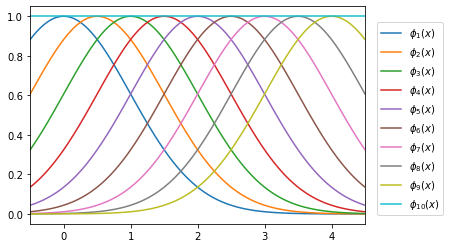

In [49]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0,4,9)
sigma = 1
for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))
plt.show()

The goal of nonlinear fitting with RBFs is to approximate the underlying function with a linear combination of these features.  By combining them in the proper manner, it is possible to approximate very general functions.

To see, this, let's go back again to the nonlinear version of the peak demand prediction problem.  We can construct a set of 10 dimensional RBFs spanning the minimum and maximum values of $x$.  For simplicity, we choose $\sigma$ to be equal to the distance between the means (this was done above, and seems reasonable, though we'll consider other ways of choosing $\sigma$ below).  Note also that there is no need to normalize the data, because the RBF features will always be scaled to be between zero and one (we could further normalize the generated features themselves, but this is typically not needed, as the features by definition will already be scaled to the range $[0,1]$).

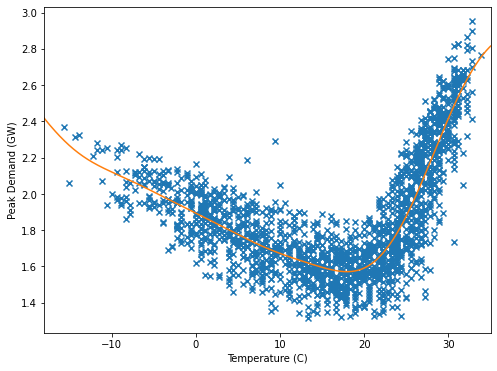

In [50]:
# create RBF features
def rbf_feat(x, mu, sig):
    return np.hstack([np.exp(-(x[:,None] - mu)**2/(2*sig**2)), np.ones((len(x),1))])

def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(-20,35, 400)
    yt = rbf_feat(xt, mu, sig) @ theta
    
    plt.figure(figsize = (8,6))
    plt.scatter(df["High_temp"], df["MAX"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Temperature (C)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([-18,35])
    plt.ylim(ylim)                  

def train_rbf(x, y, n_rbf):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
    return theta, mu, sig
    
x = df["High_temp"].values
plot_regression_rbf(*train_rbf(xp, yp, 10))

### Hyperparameters in RBFs
Unlike polynomials, where the only real hyperparameter relevant to the features themselves (not the regularization) is the degree of the polynomial, for RBF features there are a number of hyperparameter choices: the choice of centers themselves (and the number of centers as highlighted above), the bandwidth parameter $\sigma$, and the regularization parameter $\theta$.  It can be somewhat understand intuitively how we might trade off between all these different choices, and the good news is that there are some rules of thumb for choosing reasonable values for many of the hyperparameters without resorting to a grid search.  However, for the time being, we do want to briefly highlight the effect that the different hyperparameters have on the resulting performance.

**Effect of centers** We have already seen how the number of centers affects the fit of the data, so we will just briefly mention here that while the "obvious" choice for RBF centers on 1D data is to simply use an even grid over the input space, this doesn't work well for higher dimensions.  We will see more on this point shortly.

**Effect of regularization** Just like with polynomial features, we can add regularization to additionally smooth the function.  Unlike regularization for polynomial features, however, with a lot of narrow-peaked RBF functions, it is not trivial to fit the data with small weights.  This is precisely due to the local nature of the RBF features.  Because each features is only non-zero for a small part of the input space, we often cannot find a good fit to the data that has as very low weights: there is no equivalent to the "just choosing low degree terms" as we did for the polynomial.

**Effect of bandwidth parameter** The effect of the bandwidth parameter, $\sigma$, can be somewhat less obvious.  At a high-level, though, the intuition that is important here is that larger $\sigma$ leads to _smoother_ feature RBF functions, which in turns leads to smoother final functions.

## Some other regression techniques

So far we have only talked abozt parameterized regression algorithms, i.e. algorithms that make relatively strong assumptions about the functional relationship between features and dependent variable (i.e. the target).

### `KNN regression`

Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

Out of all the machine learning algorithms, KNN is easily the simplest to pick up. Despite it’s simplicity, it has proven to be effective at certain tasks. KNN can be used for both classification and regression problems. Although it is far more popular for classification problems it can perform well in regression tasks as well. One of the benefits of KNN is that it is an **unparametric** algorithm, i.e it does not make strong assumptions about the form of the mapping function. By not making assumptions, KNN is free to learn any functional form from the training data. 

In [55]:
x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

In [76]:
from sklearn.neighbors import KNeighborsRegressor

#Fit model
KNN_reg = KNeighborsRegressor(n_neighbors=12)
KNN_model = KNN_reg.fit(x_train.reshape((-1,1)), y_train) 

# Predict
y_hat_KNN = KNN_model.predict(x_test.reshape((-1,1)))

In [77]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_hat_KNN, y_test), "GW")
print("RMSE:",(mean_squared_error(y_hat_KNN, y_test))**(0.5), "GW")  
#print("R2:",r2_score(y_hat_KNN, y_test))

Test set performance:
MAE: 0.13461733865571776 GW
RMSE: 0.1661731354715458 GW


Let us visualize the results...

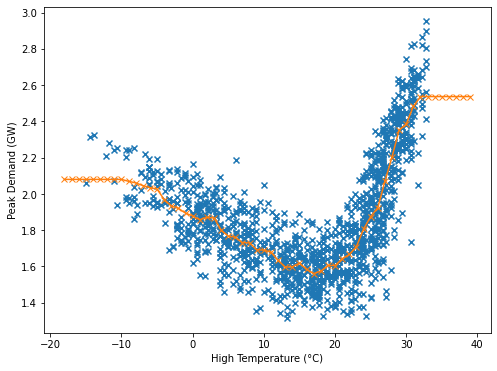

In [59]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), KNN_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

**Exercise**: What is a good choice of the number of neighbors `n_neighbors`, the key hyperparameter in KNN regression? Back up your answer with numbers. To do so write a small loop to test different values for `n_neighbors`.

In [60]:
# YOUR CODE HERE:

def find_knn (x,y):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,200):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x.reshape((-1,1)), y)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,200), err_train,np.arange(1,200), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    #plt.ylim((0,1))
    plt.show()


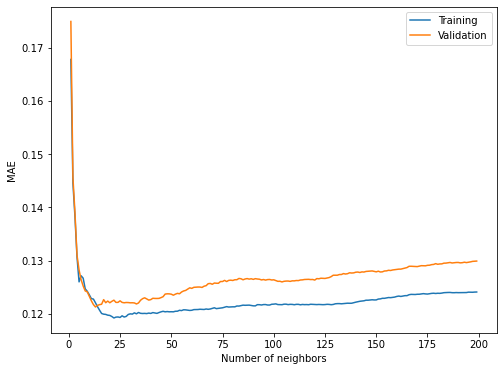

In [61]:
find_knn (xp,yp)

### `Tree-based regression`

In [74]:
# Import the necessary modules and libraries

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
Tree_reg = DecisionTreeRegressor(max_depth=5)
tree_model = Tree_reg.fit(x_train.reshape((-1,1)), y_train) 

# Predict
y_hat_tree = tree_model.predict(x_test.reshape((-1,1)))

In [75]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_hat_tree, y_test), "GW")
print("RMSE:",(mean_squared_error(y_hat_tree, y_test))**(0.5), "GW")  
#print("R2:",r2_score(y_hat_tree, y_test))

Test set performance:
MAE: 0.12751480011005473 GW
RMSE: 0.1595320383040373 GW


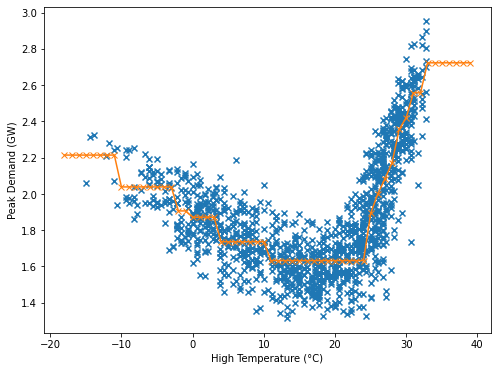

In [67]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

**Exercise**: What is a good choice of the tree depths `max_depth`, the key hyperparameter in tree regression? Back up your answer with numbers. To do so, write a small loop to test different values for `n_neighbors` and the respective error metrics. Visualize your results.

In [72]:
# YOUR CODE HERE:

def find_tree_depth (x,y):
    
    # define list for collecting results
    err_train = [] 
    err_test = []
    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)
    
    #loop over max_depth
    
    for n in np.arange(1,21): # lets test until 24 for now
        
        # fit model
        
        tree_reg = DecisionTreeRegressor(max_depth=n)
        tree_model = tree_reg.fit(x_train.reshape(-1,1),y_train)
        
        # compute errors
        
        err_train.append(mean_absolute_error(y_train, tree_model.predict(x_train.reshape(-1,1))))
        err_test.append(mean_absolute_error(y_test, tree_model.predict(x_test.reshape(-1,1))))


    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,21), err_train,np.arange(1,21), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Max Tree Depth")
    plt.ylabel("MAE")
    plt.title("Search over max_depth parameter",fontsize=14)
    #plt.ylim((0,1))
    plt.show()




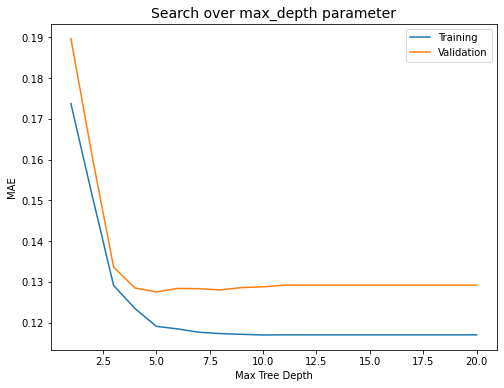

In [73]:
find_tree_depth (xp,yp)

The above exercises are what is commonly known as **grid searching an algorithm**. Grid searching is the practice of testing a large range of model hyperparameters via brute force. It is a key component of model selection and evaluation and should be carried out very thoroughly!

---